# Анализ и прогноз преступности в Башкирии

In [1]:
import sys
import pandas as pd 
import numpy as np
import json
from urllib.parse import urlencode
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats as stats
import scipy as sp
import warnings
import statsmodels.api as sm
import matplotlib 
from statsmodels.regression.linear_model import OLS
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import sklearn
%matplotlib inline


In [2]:
warnings.filterwarnings('ignore')

In [6]:
test_df = pd.read_csv('Crimes_predict_project.csv', parse_dates=['date'], index_col=['date'])

Датасет состоит из 9 столбцов

дата - наблюдения взяты с января 2013 года по декабрь 2021 года

alcoholism - количетво человек с алкогольной зависимостью, состоящие на учете (чел.)

drug_addiction - количетво человек с нарко зависимостью, состоящие на учете (чел.)

unemployment - количество безработных (тыс. чел.)

homeless - количество бездомных (чел.)

income - среднедушевой доход населения (тыс. руб.)

poverty - уровень бедности (количество людей, доход которых ниже прожиточного минимума) (чел.)

alco_sold  - количество проданного алкоголя на человека (литр)

crimes_qnty - количество преступлений всего 

Данные собраны с сайта росстата, всего 108 наблюдений (108 месяцев)

Crimes_qnty - Количество преступлений в месяц. Это переменная, которую будем прогнозировать с помощью трех моделей:

линейная регресси OLS 

sklearn регрессия с перемешанными семплами

SARIMAX

In [7]:
test_df

,alcoholism,drug_addiction,unemployment,homeless,income,poverty,alco_sold,crimes_qnty
date,,,,,,,,
2013-01-31,421,102,11.153,96,18.510,214,13.0,52
2013-02-28,270,72,12.006,112,19.503,238,4.5,33
2013-03-31,260,64,11.155,100,19.957,218,12.0,32
2013-04-30,398,81,10.593,89,20.587,200,9.0,45
2013-05-31,208,96,11.283,98,21.044,216,10.1,50
...,...,...,...,...,...,...,...,...
2021-08-31,293,73,10.367,93,27.341,202,7.1,36
2021-09-30,377,120,11.703,117,27.514,240,10.0,47
2021-10-31,276,15,10.772,92,27.735,205,8.7,15


Посмотрим на основные характеристики данных

In [229]:
round(test_df.describe(), 2)

,alcoholism,drug_addiction,unemployment,homeless,income,poverty,alco_sold,crimes_qnty
count,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00
mean,310.50,86.98,11.27,106.28,24.28,224.64,8.65,38.08
std,53.11,21.03,0.49,7.45,1.87,11.73,2.91,8.28
min,188.00,15.00,10.29,89.00,18.51,200.00,1.50,15.00
25%,274.00,74.00,10.90,101.00,23.08,216.75,6.79,33.00
50%,307.00,87.00,11.23,106.00,24.42,223.00,8.95,38.00
75%,344.25,100.25,11.64,112.00,25.43,235.00,10.50,43.25
max,452.00,134.00,12.39,126.00,28.40,256.00,17.00,60.00


In [230]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2013-01-31 to 2021-12-31
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   alcoholism      108 non-null    int64  
 1   drug_addiction  108 non-null    int64  
 2   unemployment    108 non-null    float64
 3   homeless        108 non-null    int64  
 4   income          108 non-null    float64
 5   poverty         108 non-null    int64  
 6   alco_sold       108 non-null    float64
 7   crimes_qnty     108 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 7.6 KB


Все данные числовые, пропущенных значений нет

Проверим наблюдения на нормальное распределение, что бы мы могли дальше использовать их для построения модели. Для тестирования возьмем два критерия - Шапиро-Уилка и Пирсона

In [231]:
# Тест Шапиро-Уилка
for column in test_df:
    stat, p = sp.stats.shapiro(test_df[column])
    print(column)
    print('Statistics=%.3f, p-value=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('...Отклонить гипотезу о нормальности')

alcoholism
Statistics=0.991, p-value=0.717
Принять гипотезу о нормальности
drug_addiction
Statistics=0.984, p-value=0.242
Принять гипотезу о нормальности
unemployment
Statistics=0.983, p-value=0.199
Принять гипотезу о нормальности
homeless
Statistics=0.986, p-value=0.305
Принять гипотезу о нормальности
income
Statistics=0.989, p-value=0.562
Принять гипотезу о нормальности
poverty
Statistics=0.984, p-value=0.203
Принять гипотезу о нормальности
alco_sold
Statistics=0.993, p-value=0.864
Принять гипотезу о нормальности
crimes_qnty
Statistics=0.991, p-value=0.701
Принять гипотезу о нормальности


In [232]:
# Критерий Пирсона
for column in test_df:
    stat, p = sp.stats.normaltest(test_df[column]) 
    print(column)
    print('Statistics=%.3f, p-value=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')


alcoholism
Statistics=0.756, p-value=0.685
Принять гипотезу о нормальности
drug_addiction
Statistics=4.033, p-value=0.133
Принять гипотезу о нормальности
unemployment
Statistics=5.217, p-value=0.074
Принять гипотезу о нормальности
homeless
Statistics=1.387, p-value=0.500
Принять гипотезу о нормальности
income
Statistics=2.653, p-value=0.265
Принять гипотезу о нормальности
poverty
Statistics=2.498, p-value=0.287
Принять гипотезу о нормальности
alco_sold
Statistics=0.039, p-value=0.981
Принять гипотезу о нормальности
crimes_qnty
Statistics=1.274, p-value=0.529
Принять гипотезу о нормальности


Убедимся в нормальности распределения данных с помощью графиков QQ-plot

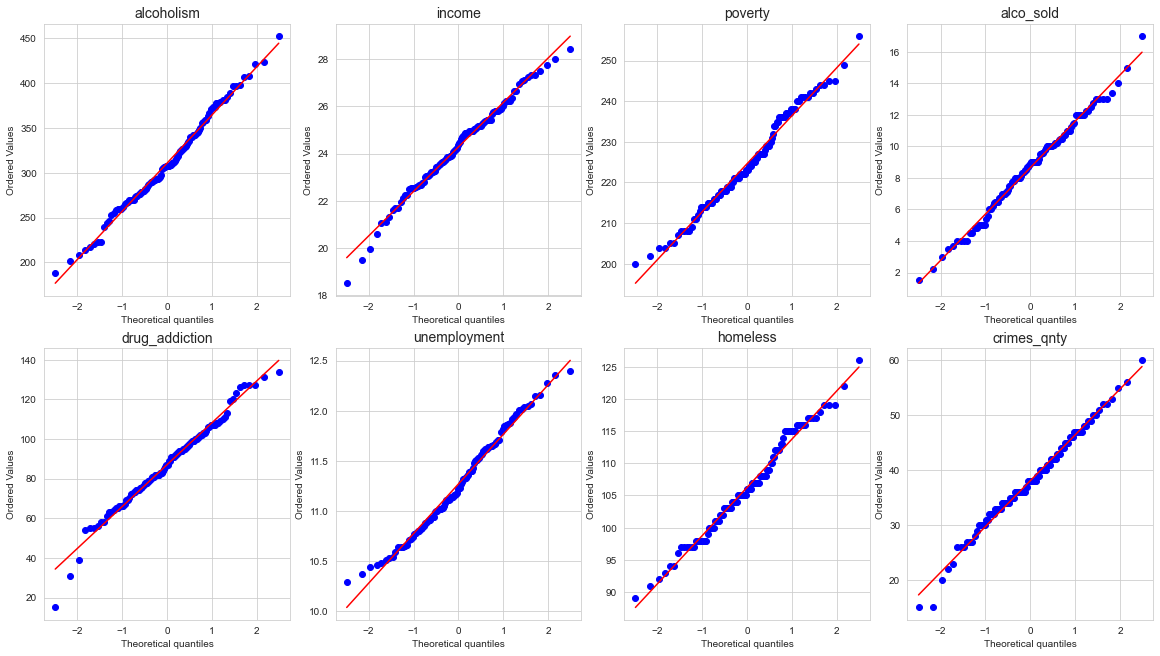

In [233]:
#Построми QQ-Plot для каждой переменной

sn.set_style("whitegrid")
fig = plt.figure(figsize=(16,9), constrained_layout=True)
gs = fig.add_gridspec(ncols=4, nrows=2)


ax_alcoholism = fig.add_subplot(gs[0,0])
ax_drug_addiction = fig.add_subplot(gs[1,0])
ax_unemployment = fig.add_subplot(gs[1,1])
ax_homeless = fig.add_subplot(gs[1,2])
ax_income = fig.add_subplot(gs[0,1])
ax_poverty = fig.add_subplot(gs[0,2])

ax_alco_sold = fig.add_subplot(gs[0,3])
ax_crimes_qnty = fig.add_subplot(gs[1,3])


stats.probplot(test_df.alcoholism, dist="norm", plot=ax_alcoholism)
ax_alcoholism.set_title("alcoholism", fontsize=14)
    
stats.probplot(test_df.drug_addiction, dist="norm", plot=ax_drug_addiction)
ax_drug_addiction.set_title("drug_addiction", fontsize=14)    
    
    
stats.probplot(test_df.unemployment, dist="norm", plot=ax_unemployment)
ax_unemployment.set_title("unemployment", fontsize=14)    
    
    
stats.probplot(test_df.homeless, dist="norm", plot=ax_homeless)
ax_homeless.set_title("homeless", fontsize=14)    
    
    
stats.probplot(test_df.income, dist="norm", plot=ax_income)
ax_income.set_title("income", fontsize=14)    
    

stats.probplot(test_df.poverty, dist="norm", plot=ax_poverty)
ax_poverty.set_title("poverty", fontsize=14)    
    

stats.probplot(test_df.alco_sold, dist="norm", plot=ax_alco_sold)
ax_alco_sold.set_title("alco_sold", fontsize=14)    
    
    
stats.probplot(test_df.crimes_qnty, dist="norm", plot=ax_crimes_qnty)
ax_crimes_qnty.set_title("crimes_qnty", fontsize=14)    
    
    
plt.show()


Данные действительно распределены нормально, с небольшим количеством выбросов.

Взглянем на гистограммы распределений

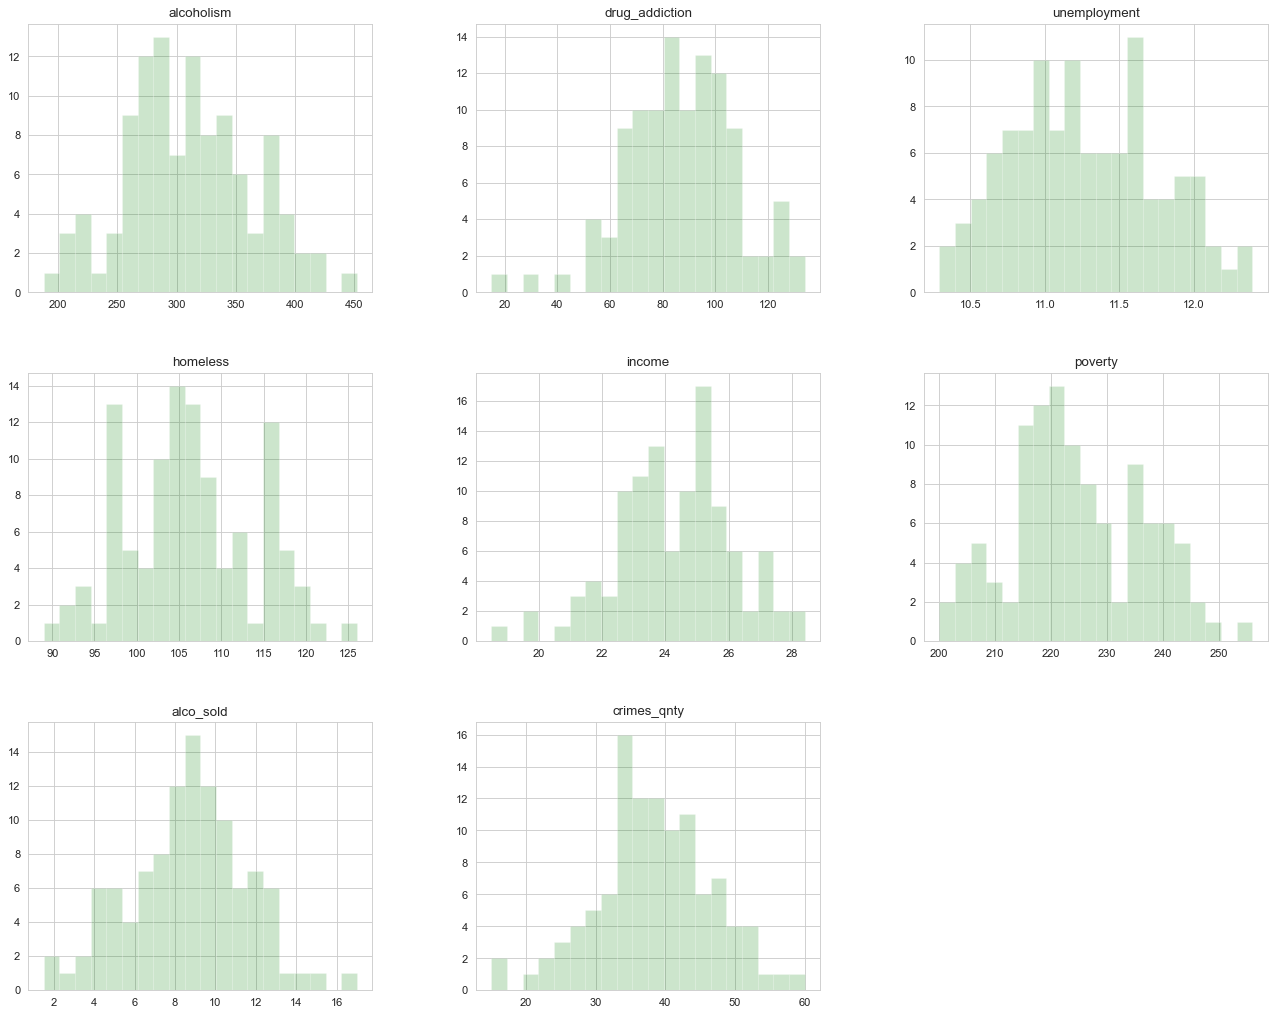

In [234]:
sn.set_style(style='whitegrid')
plt.subplots(figsize = (20, 16), dpi= 80)   

features = ['alcoholism', 'drug_addiction', 'unemployment', 'homeless', 'income', 'poverty',  'alco_sold', 'crimes_qnty']

 
histo_test_df = test_df[features].hist(bins=20, alpha = 0.2, ax = plt.subplot(), color = 'green')



Судя по графикам, есть некоторые выбросы и перекосы в распределении, посмотрим как на таких данных обучится регрессионная модель OLS

Посмотрим на парные корреляции всех переменных

<Figure size 800x640 with 0 Axes>

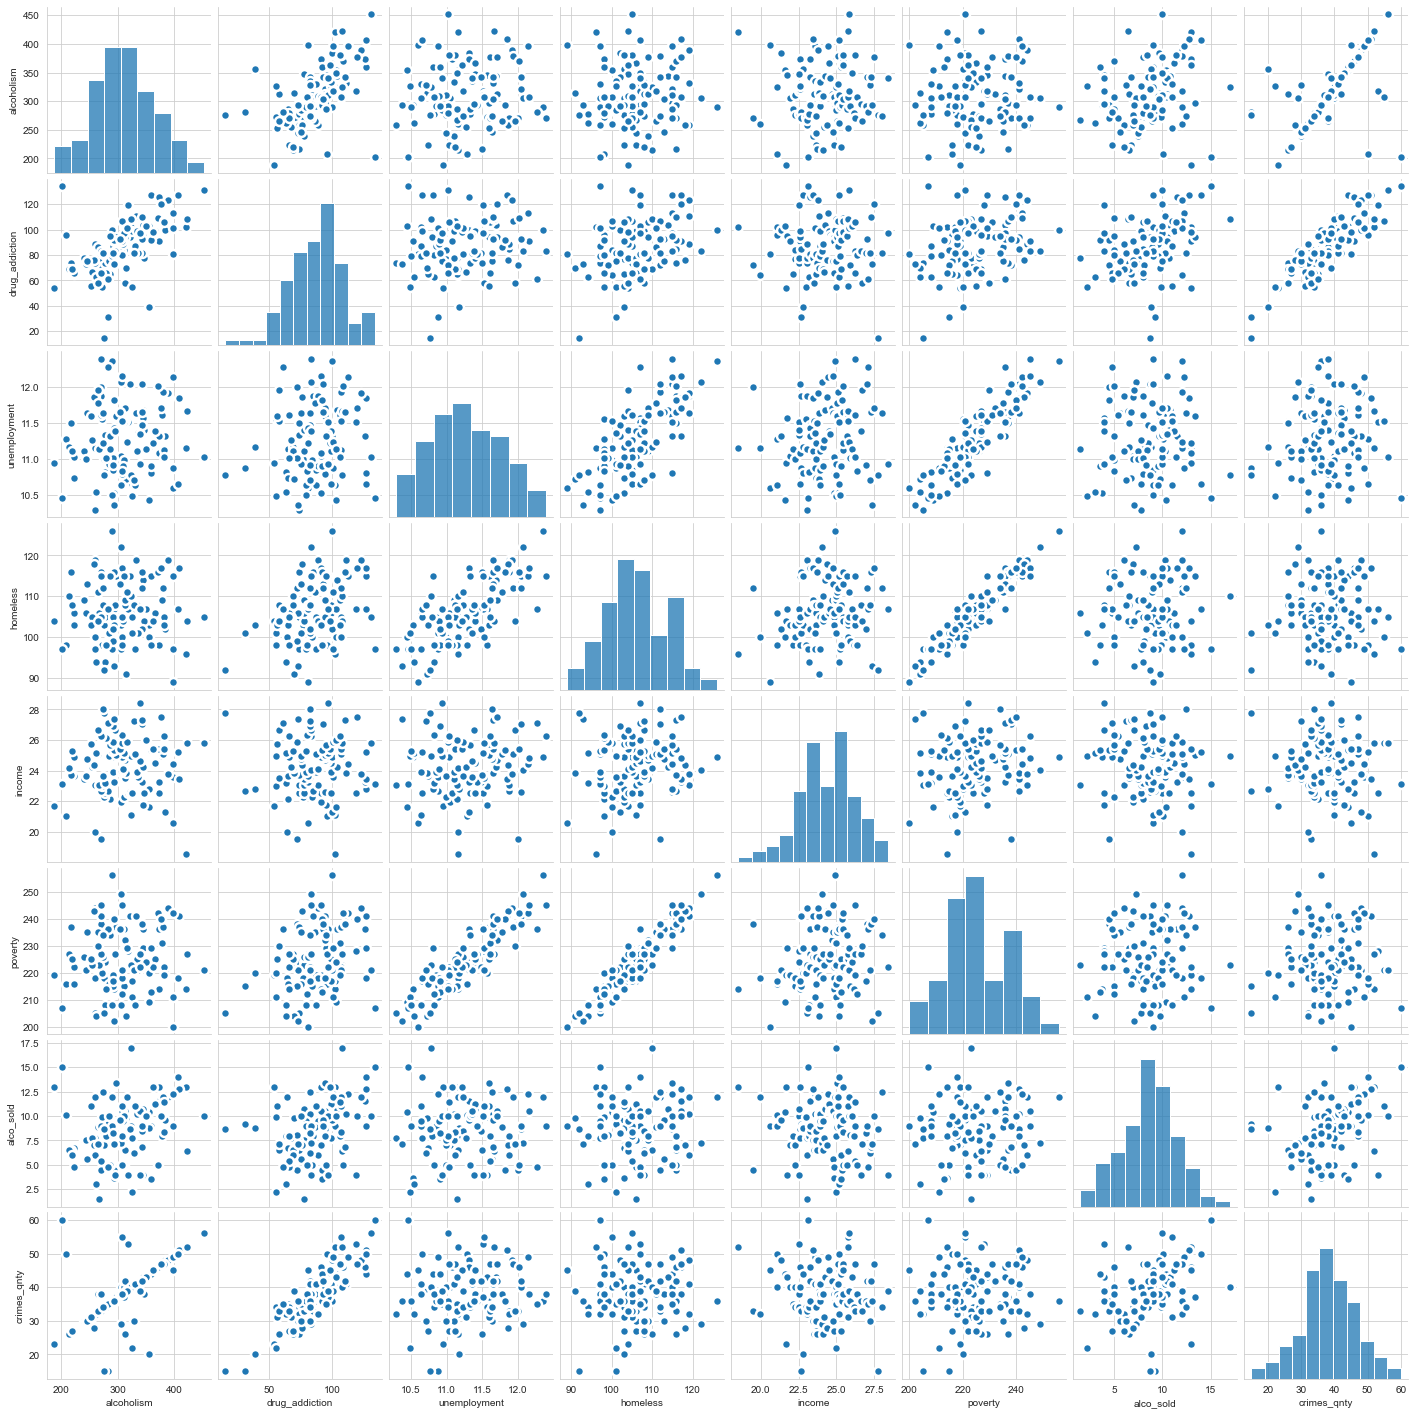

In [235]:
plt.figure(figsize=(10,8), dpi= 80)
sn.pairplot(test_df, kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

Составим корреляционную матрицу и посмортим на зависимости между переменными

In [236]:
corr = test_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,alcoholism,drug_addiction,unemployment,homeless,income,poverty,alco_sold,crimes_qnty
alcoholism,1.000000,0.585139,0.058892,0.043193,0.026547,0.050147,0.272022,0.644765
drug_addiction,0.585139,1.000000,0.145963,0.395998,0.009694,0.312908,0.344703,0.867936
unemployment,0.058892,0.145963,1.000000,0.720909,0.116172,0.898656,0.026703,0.093326
homeless,0.043193,0.395998,0.720909,1.000000,0.159818,0.950990,0.031987,0.011596
income,0.026547,0.009694,0.116172,0.159818,1.000000,0.152865,-0.123613,-0.058480
poverty,0.050147,0.312908,0.898656,0.950990,0.152865,1.000000,0.029541,0.046210
alco_sold,0.272022,0.344703,0.026703,0.031987,-0.123613,0.029541,1.000000,0.381752
crimes_qnty,0.644765,0.867936,0.093326,0.011596,-0.058480,0.046210,0.381752,1.000000


В таблице видно, что есть сильная (значения, больше 0.7) корреляция между переменными. С переменной ответа сильно связаны  alcoholism, drug_addiction и есть слабая корреляция с  alco_sold. Остальные переменные не оказывают заметного влияния на преступность 

## Построим регрессионную модель с помощью OLS из statsmodels

Разделим данные на тестовую и тренировочную части

In [127]:
x_train = test_df[['drug_addiction', 'alcoholism', 'unemployment', 'homeless', 'income', 'poverty',  'alco_sold']][:-22]
x_test = test_df[['drug_addiction', 'alcoholism', 'unemployment', 'homeless', 'income', 'poverty',  'alco_sold']][-22:]
y_train = test_df['crimes_qnty'][:-22]
y_test = test_df['crimes_qnty'][-22:]

Построим первую модель со всеми предикторами

In [128]:
# зависимые переменные
y = y_train
# независимая переменная
X = sm.add_constant(x_train)

# обучение модели
ols_model = sm.OLS(endog=y, exog=X).fit()
# вывод результатов (так же можно print(model.summary()))
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            crimes_qnty   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     6195.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):          2.59e-104
Time:                        11:35:11   Log-Likelihood:                -31.933
No. Observations:                  86   AIC:                             79.87
Df Residuals:                      78   BIC:                             99.50
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.0445      1.144     -2.662      0.009      -5.321      -0.768
drug_addiction     0.4333      0.003    154.832      0.000       0.428       0.439
alcoholism         0.0002      0.001      0.254      0.800      -0.002       0.002
unemployment      12.1361      1.084     11.199      0.000       9.979      14.294
homeless          -0.5217      0.100     -5.191      0.000      -0.722      -0.322
income             0.0383      0.028      1.372      0.174      -0.017       0.094
poverty           -0.3526      0.101     -3.504      0.001      -0.553      -0.152
alco_sold          0.0441      0.015      3.006      0.004       0.015       0.073
==============================================================================
Omnibus:                        0.982   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.612   Jarque-Bera (JB):                0.924
Skew:                           0.018   Prob(JB):                        0.630
Kurtosis:                       2.493   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

В результате получаем много значимых предикторов, но среди них есть мультиколлинеарные, исключим их из модели, оставим те, которые имеют связь сильнее чем остальные (по корреляционной матрице)

In [129]:
x_train = test_df[[ 'drug_addiction', 'unemployment', 'income', 'alco_sold']][:-22]


In [130]:
# зависимые переменные
y = y_train
# независимая переменна
X = sm.add_constant(x_train)

# обучение модели
ols_model = sm.OLS(endog=y, exog=X).fit()
# вывод результатов (так же можно print(model.summary()))
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            crimes_qnty   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     68.41
Date:                Sat, 10 Sep 2022   Prob (F-statistic):           3.43e-25
Time:                        11:35:11   Log-Likelihood:                -240.31
No. Observations:                  86   AIC:                             490.6
Df Residuals:                      81   BIC:                             502.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             33.3688     11.926      2.798      0.006       9.640      57.097
drug_addiction     0.3489      0.024     14.429      0.000       0.301       0.397
unemployment      -1.1163      0.940     -1.187      0.239      -2.987       0.755
income            -0.6805      0.298     -2.282      0.025      -1.274      -0.087
alco_sold          0.3183      0.159      2.000      0.049       0.002       0.635
==============================================================================
Omnibus:                        0.981   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.612   Jarque-Bera (JB):                1.032
Skew:                           0.155   Prob(JB):                        0.597
Kurtosis:                       2.561   Cond. No.                     2.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Из предикторов, что мы оставили в модели, влияние предиктора unemployment на переменную ответа не имеет статистической значимости (p-value > 0,05), поэтому исключим ее из модели и посмотрим на конечный результат

In [145]:
x_train = test_df[['drug_addiction', 'income', 'alco_sold']][:-22]


In [146]:
# зависимые переменные
y = y_train
# независимая переменная
X = sm.add_constant(x_train)

# обучение модели
ols_model = sm.OLS(endog=y, exog=X).fit()
# вывод результатов (так же можно print(model.summary()))
ols_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            crimes_qnty   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     90.30
Date:                Sat, 10 Sep 2022   Prob (F-statistic):           6.61e-26
Time:                        11:42:36   Log-Likelihood:                -241.05
No. Observations:                  86   AIC:                             490.1
Df Residuals:                      82   BIC:                             499.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.0590      7.191      3.068      0.003       7.754      36.364
drug_addiction     0.3444      0.024     14.387      0.000       0.297       0.392
income            -0.7179      0.297     -2.415      0.018      -1.309      -0.127
alco_sold          0.3216      0.159      2.017      0.047       0.004       0.639
==============================================================================
Omnibus:                        1.333   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                1.257
Skew:                           0.163   Prob(JB):                        0.533
Kurtosis:                       2.505   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

В моделе остались только значимые предикторы, хотя в корреляционной матрице income не имеет сильной связи с переменной ответа, в модели она имеет статистическую значимость. Единственная проблема связана с числом обусловленности (Cond.No. 1.52e+03). Данный параметр отражает, насколько чувствительна функция к изменениям или ошибкам на входе и насколько ошибка на выходе является результатом ошибки на входе. Попробуем удалить income и посмотреть как изменится ситуация

In [166]:
x_train = test_df[['drug_addiction', 'alco_sold']][:-22]
x_test = test_df[['drug_addiction', 'alco_sold']][-22:]

In [151]:
# зависимые переменные
y = y_train
# независимая переменная
X = sm.add_constant(x_train)

# обучение модели
ols_model = sm.OLS(endog=y, exog=X).fit()
# вывод результатов (так же можно print(model.summary()))
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            crimes_qnty   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     125.2
Date:                Sat, 10 Sep 2022   Prob (F-statistic):           8.60e-26
Time:                        11:48:03   Log-Likelihood:                -244.00
No. Observations:                  86   AIC:                             494.0
Df Residuals:                      83   BIC:                             501.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.4387      2.145      2.536      0.013       1.173       9.705
drug_addiction     0.3371      0.024     13.801      0.000       0.289       0.386
alco_sold          0.3527      0.164      2.157      0.034       0.027       0.678
==============================================================================
Omnibus:                        2.613   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.058
Skew:                           0.231   Prob(JB):                        0.357
Kurtosis:                       2.400   Cond. No.                         427.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Теперь с обусловленностью в моделе все хорошо, хоть модель и потеряла незначительно в объясняющей способности и показателе AIC. Зато F-статистика улучшилась, значит в общем адекватность модели повысилась

Выведем формулу регрессии

In [152]:
ols_model.params

const             5.438717
drug_addiction    0.337143
alco_sold         0.352722
dtype: float64

In [154]:
for param in ols_model.params:
    if param > 0:
        sign="+"
                
    elif param < 0:
        sign="-"
                
    formula = f"y = {ols_model.params[0]:.2f} {sign} {np.abs(ols_model.params[1]):.2f}*x1  {sign} {np.abs(ols_model.params[2]):.2f}*x2"    
    
print("-"*80) 

print("OLS Formula: ", formula)

print("-"*80) 

--------------------------------------------------------------------------------
OLS Formula:  y = 5.44 + 0.34*x1  + 0.35*x2
--------------------------------------------------------------------------------


Данная формула говорит, что при увеличении количества наркозависимых на одного человека , преступность вырастет на 0.34, а  при увеличении продаж алкоголя на один литр на человека преступность увеличится на 0.35.

Модель в общем потеряла объясняющую способность (скорректированный коэфициент детерминации был 0.759, а стал 0.745), так же ухудшился показатель AIC с 490.1 до 494. Коэффициент детерминации показывает сильно выраженную тесноту связи - 0.745. Это говорит о том, что включенные в модель независимые переменные могут обьяснить изменчивость 75 % данных. Значение теста Дарбина - Ватсона лежит в диапазоне 1.5 - 2.5 - значит автокорреляции остатков не наблюдается. Очевидно, что с переменными не все в порядке в плане нормальности (показатели Omnibus и Skew  косвенно указывают на ассиметрию остатков) 

Посмотрим на распределение остатков

In [167]:
model_resid = ols_model.resid
model_resid

date
2013-01-31    7.587307
2013-02-28    1.699734
2013-03-31    0.751466
2013-04-30    9.078199
2013-05-31    8.633059
                ...   
2019-10-31    6.309594
2019-11-30    1.935880
2019-12-31   -4.230918
2020-01-31    2.801332
2020-02-29    9.607035
Length: 86, dtype: float64

In [168]:
model_resid.describe()

count    8.600000e+01
mean    -6.774942e-15
std      4.154293e+00
min     -7.846438e+00
25%     -2.751653e+00
50%      8.183852e-02
75%      2.563121e+00
max      9.607035e+00
dtype: float64

<AxesSubplot:>

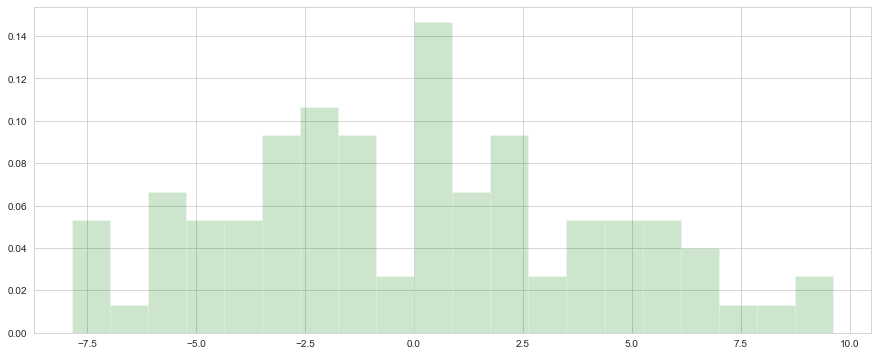

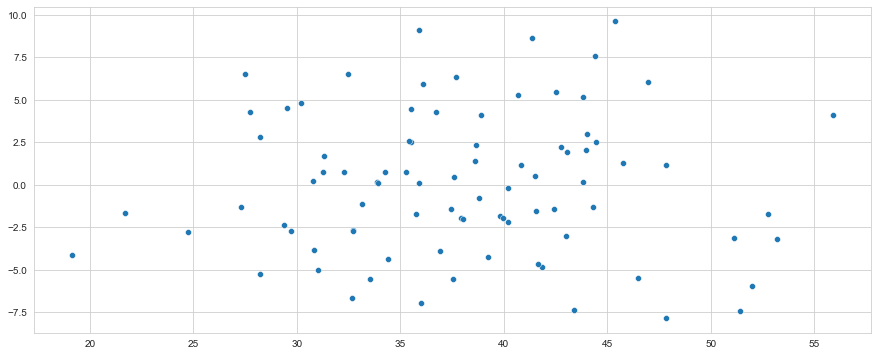

In [169]:
plt.figure(figsize=(15, 6))
model_resid.hist(bins=20, density=True, alpha = 0.2, color = 'green')

plt.figure(figsize=(15, 6))

sn.scatterplot(x=ols_model.fittedvalues, y=model_resid)

<AxesSubplot:xlabel='drug_addiction'>

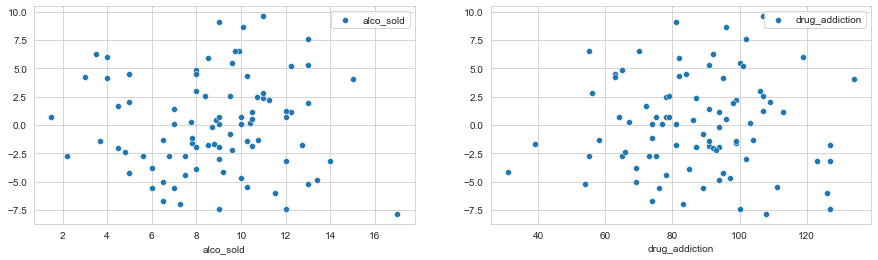

In [170]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
sn.scatterplot(x=test_df.alco_sold[:-22], y=model_resid, label="alco_sold", ax=axes[0])
sn.scatterplot(x=test_df.drug_addiction[:-22], y=model_resid, label="drug_addiction", ax=axes[1])

Явной корреляции остатков с независимыми переменными нет, гетероскедантичности не наблюдается, значения расположены вокруг нуля

Jarque-Bera test: 2.0583, p-value: 0.3573032496327403
Shapiro-Wilk test: 0.9832, p-value: 0.3268
Kolmogorov-Smirnov test: 0.3542, p-value: 0.0000
Anderson-Darling test: 0.3355, 5% critical value: 0.7540


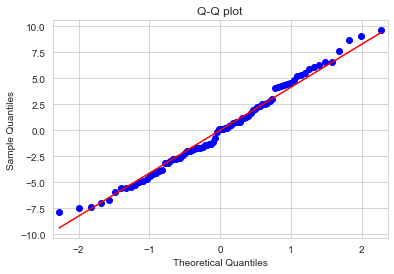

In [171]:
def normality_of_residuals_test(model):
    
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');
    
    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')

normality_of_residuals_test(ols_model)

Согласно графикам и тестам остатки  распределены относительно нормально

Возможные варианты как привести к более нормальному распределению для повышения точности модели:

- удалить / обработать потенциальные выбросы

- преобразование целевой переменной или признаков (логарифм, квадратный корень или обратную величину независимой и/или зависимой переменной)

- использовать смешанные модели

Попробуем построить прогноз для значений вне выборки

In [172]:
x_future = sm.add_constant(x_test)
y_future = ols_model.predict(x_future) 
y_pred = ols_model.predict(X) 

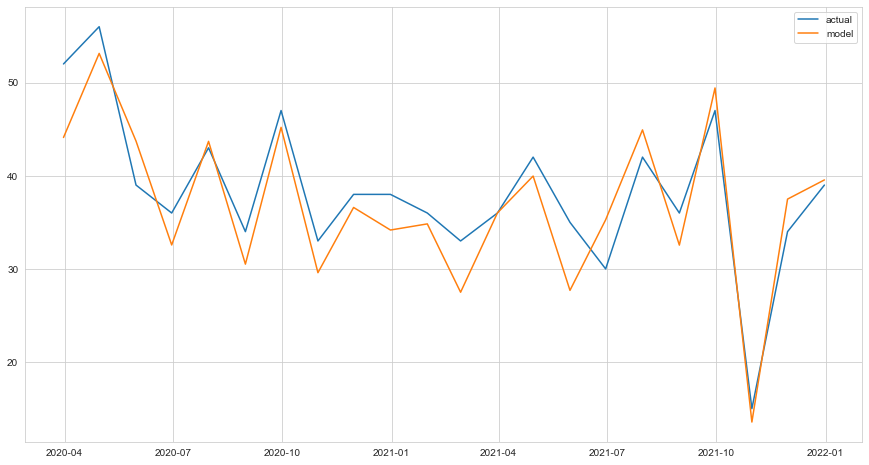

In [173]:
plt.figure(figsize=(15, 8))
plt.plot(y_test, label="actual")
plt.plot(y_future, label="model")

plt.legend()

Посмотрим на прогнозные значения и оценим модель с помощью MSE и MAE

In [174]:
y_all_pred = y_pred.append(y_future).sort_index()

In [175]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_future))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_future))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_future)))

Mean Absolute Error: 3.140596257459602
Mean Squared Error: 13.928759324412361
Root Mean Squared Error: 3.7321253093126927


Модель ошибается  на 3 преступления, неплохой результат

Посмотрим на общий прогноз на весь период

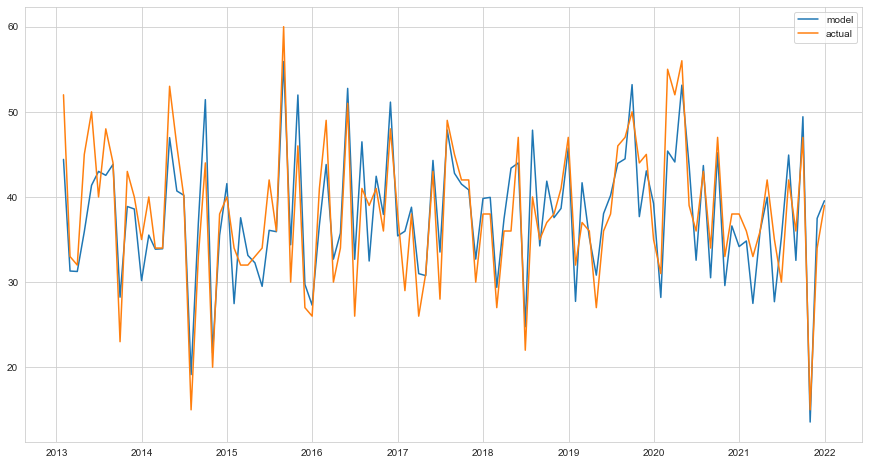

In [176]:
plt.figure(figsize=(15, 8))
plt.plot(y_pred.append(y_future).sort_index(), label="model")
plt.plot(test_df.crimes_qnty, label="actual")
plt.legend()

Посмотрим на прогнозные значения и оценим модель с помощью MSE и MAE

In [177]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_df.crimes_qnty, y_all_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_df.crimes_qnty, y_all_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_df.crimes_qnty, y_all_pred)))

Mean Absolute Error: 3.3428613193908867
Mean Squared Error: 16.420143437664564
Root Mean Squared Error: 4.0521776167468975


Наша модель ошибается примерно на 3 преступления (Mean Absolute Error), среднеквадратичная ошибка показывает не очень хороший результат 16.4. Скорее всего на увеличение MSE повлияло то, что есть некоторые выбросы в данных тренировочной выборки.
Так как оценка MSE является не робастной в целом, а MAE более устойчива, вероятнее всего по результатам оценок,  в данных есть выбросы, которые влияют на размер MSE , при том что MAE показывает удовлетворительные результаты.

## Построим регрессию с помощью sklearn

Поделим данные на тестовую и тренировочную части с перемешиванием

In [178]:
X = test_df[[ 'drug_addiction', 'alco_sold']]
y = test_df['crimes_qnty']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель

In [180]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

Посмотрим на коэффициенты регресии

In [181]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
drug_addiction,0.328619
alco_sold,0.266712


Посмотрим на массив прогнозных значений

In [182]:
y_pred = regressor.predict(X_test)
y_pred

array([28.32805484, 38.76287547, 31.26654433, 31.22371905, 27.70605293,
       28.31753778, 39.93445485, 43.61312398, 40.36314554, 44.18937261,
       41.45568741, 35.47766081, 37.98182256, 40.01544435, 38.42471535,
       44.03509213, 34.16220854, 41.53472491, 45.08762725, 47.39273125,
       32.87440344, 28.20424006])

In [183]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.sort_index(inplace=True)
df

,Actual,Predicted
date,,
2013-03-31,32,31.223719
2013-08-31,44,43.613124
2013-09-30,23,28.204240
2013-11-30,40,38.762875
2014-02-28,34,34.162209
2014-05-31,46,40.363146
2014-11-30,38,35.477661
2015-01-31,34,27.706053
2016-10-31,36,37.981823


Построим график прогноза на тестовых данных 

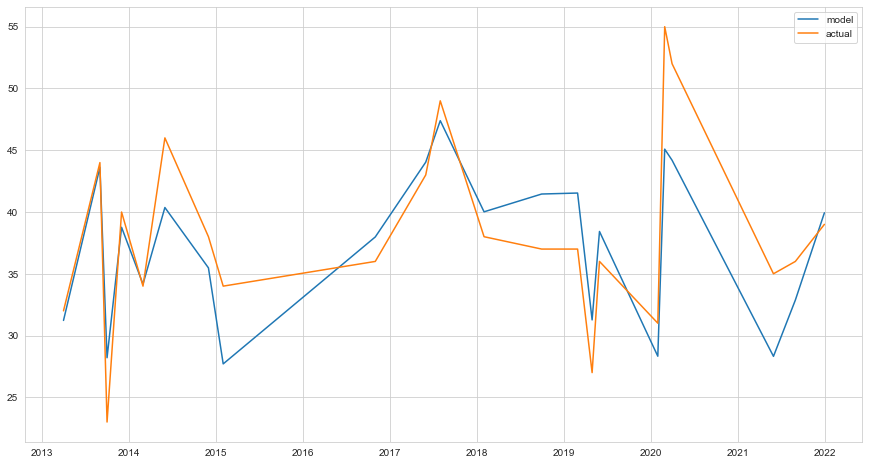

In [184]:
plt.figure(figsize=(15, 8))
plt.plot(df.Predicted, label="model")
plt.plot(df.Actual, label="actual")
plt.legend()

Оценим модель с помощью метрик 

In [185]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.4399377059302436
Mean Squared Error: 18.40842534634093
Root Mean Squared Error: 4.290504090003986


Наша модель ошибается почти на два преступления, это небольшое отклонение.
Очевидно среднеквадратичная ошибка регрессии из модуля sklearn  равная 18 больше чем у варианта с разделенными на части данными модели OLS (13.9), так же абсолютное отклонение увеличилось с 3.1 до 3.4, что характеризует ее, как худший вариант для прогноза. Это связано с тем, что мы использовали специальный метод сплитиррования, который нарезает данные рандомно, то есть не последовательно по дате, а выбирает даты хаотично, не учитывая зависимость во времени

Так как предыдущие две модели не учитывали зависимость от времени, попробуем построить модель для прогнозирования временных рядов с сезонной компонентой

## Перейдем к моделе SARIMAX

Посмотрим на временной ряд преступности и найдем оптимальные параметры составляющей SARIMAX (p, d, q)  и сезонных компонентов (P, D, Q, s) 

<AxesSubplot:xlabel='date', ylabel='drug_addiction'>

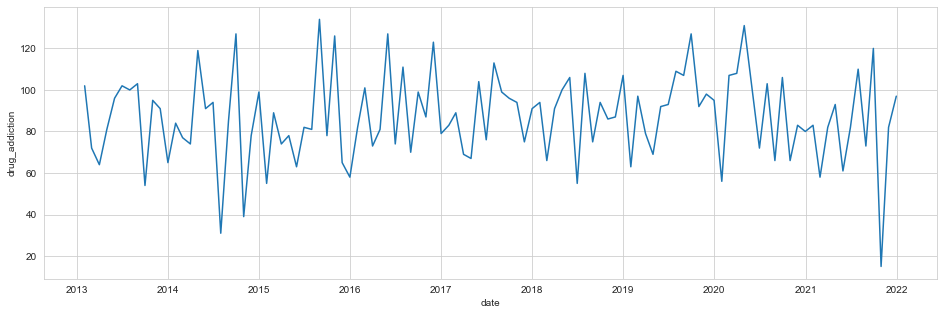

In [186]:
sn.set_style(style='whitegrid')
plt.figure(figsize=(16, 5))
sn.lineplot(data=test_df['drug_addiction'])

Декомпозируем ряд

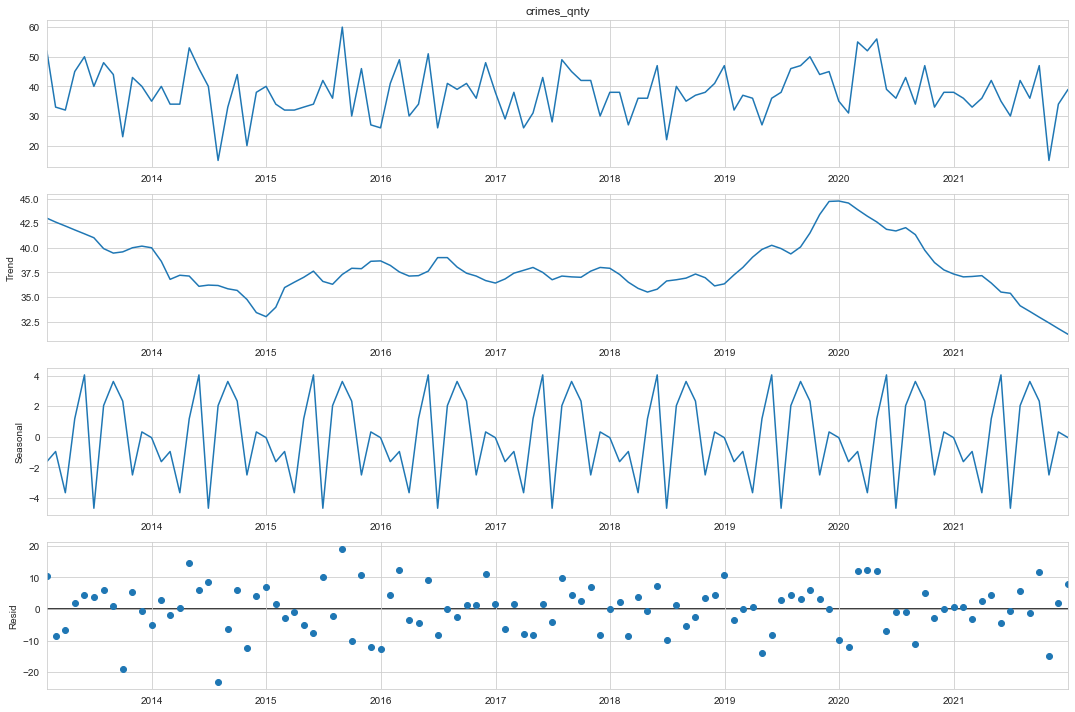

In [187]:
result_add = seasonal_decompose(test_df['crimes_qnty'], extrapolate_trend = 'freq')

plt.rcParams.update({'figure.figsize': (15,10)})

result_add.plot()
plt.show()

Глядя на график, можно заключить, что явный тренд отсутсвует, а сезонность составляет примерно 12 месяцев

Построим графики автокорреляции и частной автокорреляции

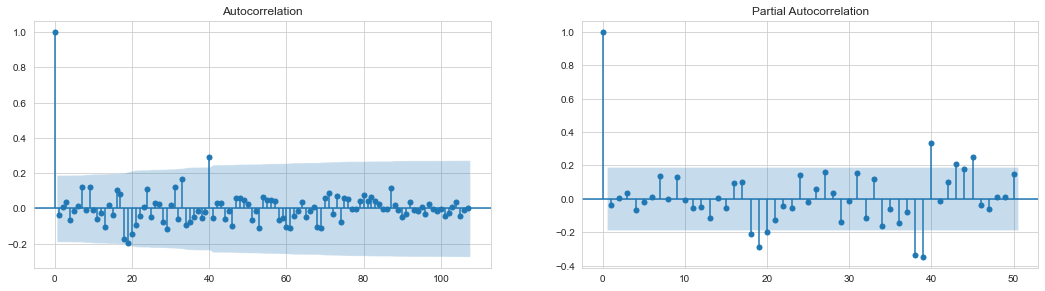

In [188]:
fig = plt.figure(figsize=(18, 10))
layout = (2, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

smt.graphics.plot_acf(test_df.crimes_qnty, lags=107, ax=acf_ax)
smt.graphics.plot_pacf(test_df.crimes_qnty, lags = 50, ax=pacf_ax)
plt.show()

В целом график корреляции постепенно затухает и сильных значимых корреляций преимущественно нет

Проверим стационарность ряда тестом Дики - Фуллера

In [16]:
def stationarity(series):
    dftest = adfuller(series)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('Ряд стационарен')
    else:
        print('Ряд не стационарен')
        
stationarity(test_df.crimes_qnty)

Ряд стационарен


Проверим стационарность сезонной составляющей

In [190]:
seasonal = result_add.seasonal
stationarity(seasonal)

Ряд стационарен


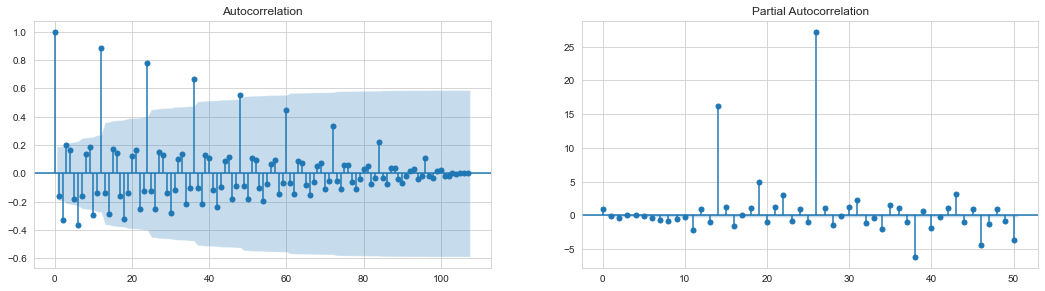

In [191]:
fig = plt.figure(figsize=(18, 10))
layout = (2, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

smt.graphics.plot_acf(seasonal, lags=107, ax=acf_ax)
smt.graphics.plot_pacf(seasonal, lags = 50, ax=pacf_ax)
plt.show()

<AxesSubplot:xlabel='date'>

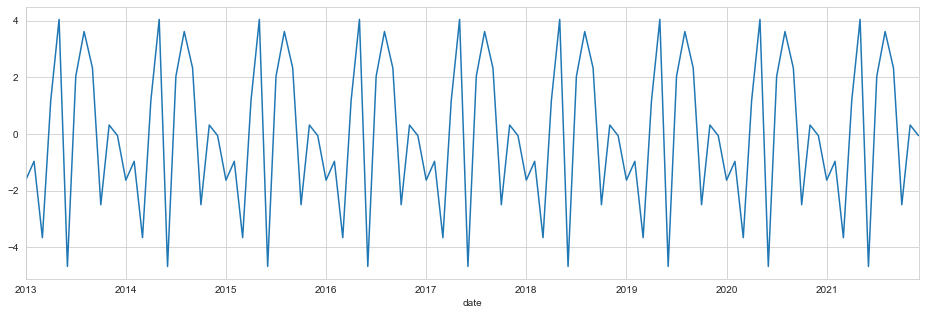

In [192]:
plt.figure(figsize=(16, 5))
seasonal.plot()

Обе последовательности стационарны, следовательно параметры d, D равны нулю.

Проверка белого шума

In [193]:
from statsmodels.stats.diagnostic import acorr_ljungbox

print(acorr_ljungbox(result_add.resid, lags=1))

(array([1.56539778]), array([0.21087663]))


p_value = 0.21351502, значит последовательность считается белым шумом

Поделим данные без перемешивания

In [10]:
x = test_df[[ 'drug_addiction', 'alco_sold']]
y = test_df['crimes_qnty']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=False)

Попробуем построить модель без параметров, внешних переменных и сезонной компоненты

In [219]:
best_model = ARIMA(y_train, order=(0, 0, 0)).fit()
print(best_model.summary())   

                               SARIMAX Results                                
Dep. Variable:            crimes_qnty   No. Observations:                   86
Model:                          ARIMA   Log Likelihood                -303.803
Date:                Sat, 10 Sep 2022   AIC                            611.606
Time:                        12:24:01   BIC                            616.515
Sample:                    01-31-2013   HQIC                           613.582
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.0465      0.894     42.577      0.000      36.295      39.798
sigma2        68.5327     10.399      6.591      0.000      48.152      88.914
Ljung-Box (L1) (Q):                   0.70   Jarque-

Значение AIC - 612, попробуем улучшить модель, добавив независимые переменные

Подберем параметры p, q, P, Q перебором и выберем тот набор параметров, у которого самый низкий показатель AIC

In [25]:
ps = range(0, 5)
d=0
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [26]:
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(y_train,
                                        exog= sm.add_constant(x_train),
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 34%|███████████████████████████▌                                                     | 34/100 [00:45<02:25,  2.20s/it]C:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 35%|████████████████████████████▎                                                    | 35/100 [00:52<03:47,  3.50s/it]C:\Anacon

      parameters         aic
53  (2, 2, 3, 0)  445.731808
23  (1, 0, 3, 0)  446.887806
24  (1, 0, 4, 0)  447.010031
4   (0, 0, 4, 0)  447.208696
8   (0, 1, 3, 0)  447.276927


Самый низкий AIC - 516, построим модель с параметрами равными нулю, добавим сезонность 12 месяцев

In [45]:
best_model = sm.tsa.statespace.SARIMAX(y_train, 
                                       exog= sm.add_constant(x_train), 
                                       order=(0, 0, 0), 
                                       seasonal_order=(0, 0, 0, 0)).fit(disp=-1)
print(best_model.summary())   

C:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:            crimes_qnty   No. Observations:                   86
Model:                        SARIMAX   Log Likelihood                -244.002
Date:                Sun, 25 Sep 2022   AIC                            496.004
Time:                        10:16:08   BIC                            505.821
Sample:                    01-31-2013   HQIC                           499.955
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.4391      2.178      2.497      0.013       1.170       9.709
drug_addiction     0.3371      0.023     14.557      0.000       0.292       0.382
alco_sold          0.3530      0.149

Все коэффициенты значимы (p < 0.05), оставляем модель без изменений

Показатель AIC улучшился с 611 до 496, оставим эту модель для прогноза

C:\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


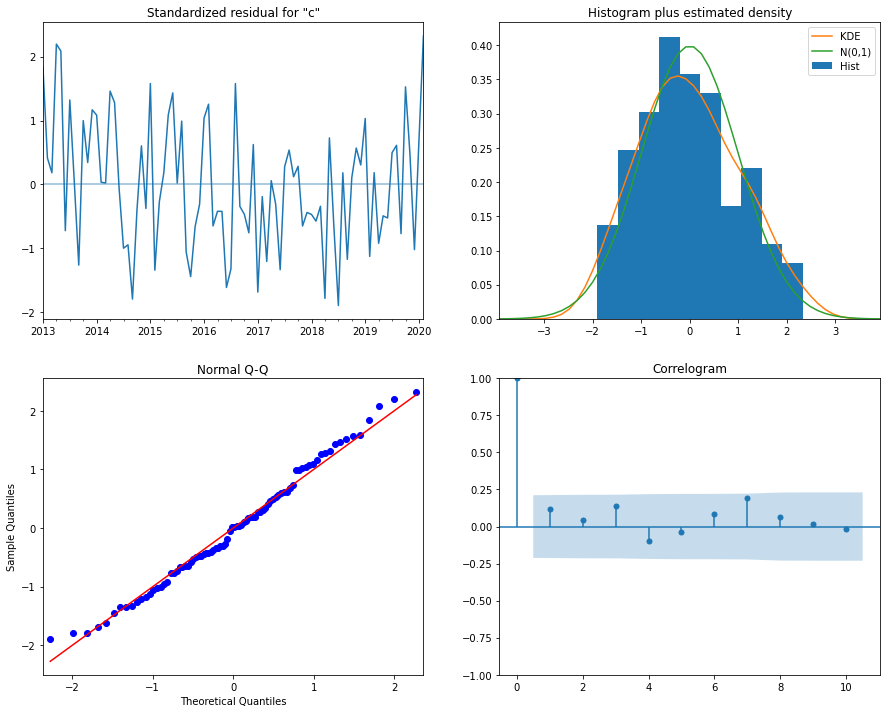

In [46]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

В целом остатки распределены нормально, есть несущественные отклонения от нормального распределния (нужна обработка выбросов)

Построим график автокорреляции для остатков модели.

Нужно убедиться, что остатки:

- имеют низкое абсолютное значение, в них отсутствует тренд и циклы;

- распределены нормально со средним ~0;

- отсутствует автокорреляция (смотрим коррелограмму и  тест "Ljung-Box")

Результат теста Люинга - Бокса в выведенной модели (Prob(Q) > 0.05) показывает, что остатки не автокоррелированы, являются белым шумом

Применим тест Дики - Фуллера

In [33]:
stationarity(best_model.resid)

Ряд стационарен


<AxesSubplot:>

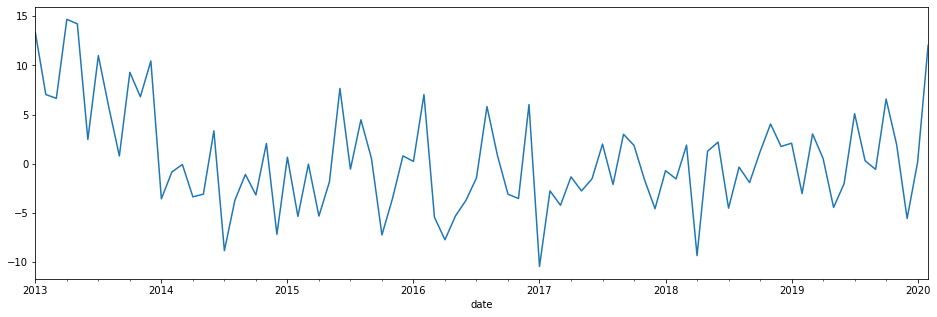

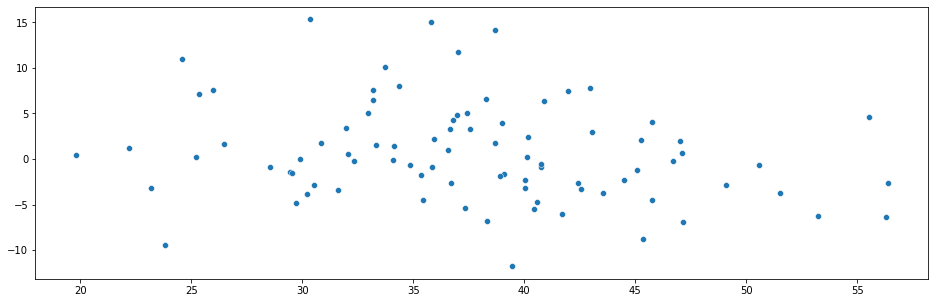

In [34]:
plt.figure(figsize=(16, 5))
best_model.resid.plot()
plt.figure(figsize=(16, 5))
sn.scatterplot(x=best_model.fittedvalues, y=model.resid)

Посмотрим коррелограмму остатков подробнее

C:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


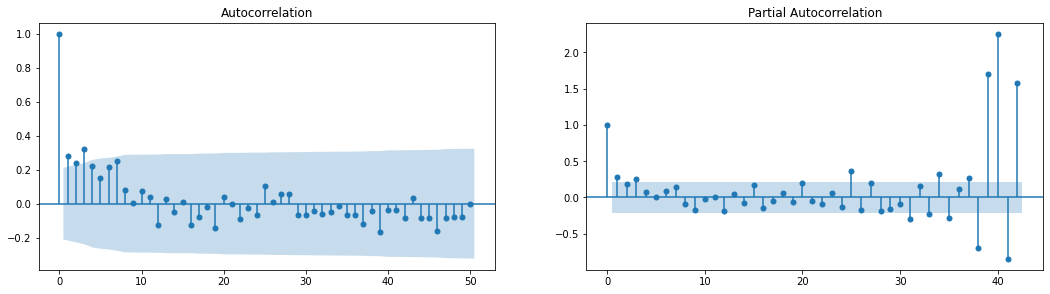

In [35]:
fig = plt.figure(figsize=(18, 10))
layout = (2, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

smt.graphics.plot_acf(best_model.resid, lags=50, ax=acf_ax)
smt.graphics.plot_pacf(best_model.resid, lags = 42, ax=pacf_ax)
plt.show()

Остатки стационарны и являются белым шумом,  имеют низкую корреляцию с запаздывающими данными, можем построить прогноз по получившейся модели

Построим прогноз на тренировочных данных

In [36]:
train_predict = best_model.predict(start='2013-01-31', end='2020-02-29', exog=sm.add_constant(x_train))
train_predict

C:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2013-01-31    38.663683
2013-02-28    25.965234
2013-03-31    25.350026
2013-04-30    30.328061
2013-05-31    35.783571
                ...    
2019-10-31    37.424692
2019-11-30    43.037661
2019-12-31    40.553593
2020-01-31    30.826381
2020-02-29    42.957917
Freq: M, Name: predicted_mean, Length: 86, dtype: float64

Попробуем построить прогноз на будущее на тестовых данных

In [37]:
test_predict = best_model.get_forecast(steps=22, exog=sm.add_constant(x_test))
# Получить значения прогноза
test_predict = test_predict.predicted_mean

Построим график прогноза на 108 месяцев 

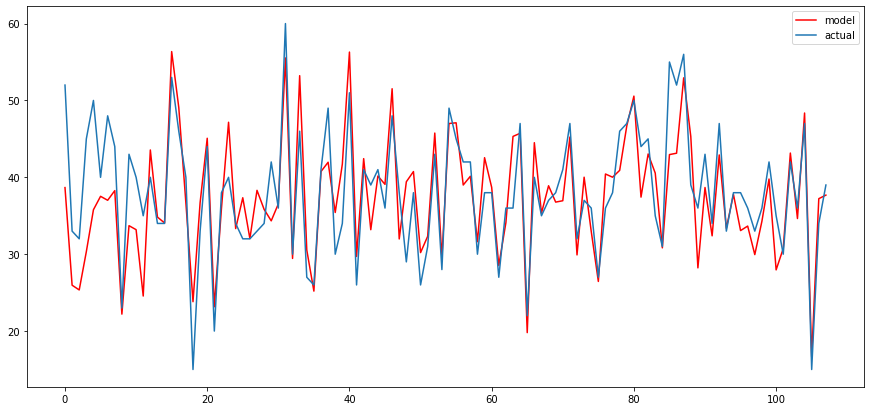

In [38]:
forecast = test_predict
forecast = train_predict.append(forecast).values
actual = test_df.crimes_qnty.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.plot(actual, label="actual")
plt.legend()


Посмотрим на ошибки

In [39]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_df.crimes_qnty, forecast ))
print('Mean Squared Error:', metrics.mean_squared_error(test_df.crimes_qnty, forecast))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_df.crimes_qnty,forecast)))

Mean Absolute Error: 3.8495858763462163
Mean Squared Error: 25.452480692247423
Root Mean Squared Error: 5.045045162557757


# Заключение

Исходя из результатов метрик всех трех моделей, худший результат показала регрессия sklearn(потому что использовали сплитирование с перемешиванием). 
модель SARIMAX в нашем случае оказалась без параметров, поэтому результаты получились как у регрессии OLS.
Можно пробовать дальше настраивать параметры SARIMAX, так как метод перебора параметров не всегда дает оптимальный результат. Так же, можно попробовать метод разностей, что бы сгладить незначительные локальные тренды и сезонность.

В целом, модели неплохо справились с прогнозом, абсолютная ошибка получается небольшой, но, так как в данных присутствуют выбросы, среднеквадратичная ошибка получается довольно высокой 16.4 (выше 10% от значений crimes_qnty).
Для дальнейшего улучшения моделей можно применять логарифмирование, нормализации, обработку выбросов.

Результаты исследования (y = 5.44 + 0.34*x1  + 0.35*x2) показывают, что на преступность в Башкирии влияют примерно в одинаковой  степени наркотизация общества и продажи алкоголя. Так как алоголизм явно коррелировал с наркоманией, хотя имел тесную связь с преступностью, мы исключили его из модели, что бы избавиться от мультиколлинеарности. Но, все же, косвенно можно увидеть влияние алкоголизма через продажу алкоголя. Судя по формуле регрессии, достаточной мерой для сокращения преступности было бы сокращение потребления алкоголя на человека в месяц и снижения показателя наркозависимых в Республике.

# Спасибо за внимание!